<a href="https://colab.research.google.com/github/Bprs68/Rossmann-Sales-Prediction-/blob/main/Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [47]:
#importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
# setting folder path for location where store data is kept
file_path_stores_data= '/content/drive/MyDrive/AlmaBetter/Team Capstone Projects/Capstone Project - Supervised Machine Learning- Regression/Data/Copy of store.csv'
file_path_rossman_stores_data = '/content/drive/MyDrive/AlmaBetter/Team Capstone Projects/Capstone Project - Supervised Machine Learning- Regression/Data/Copy of Rossmann Stores Data.csv'

In [50]:
#reading csv from rossman stores data file path
df = pd.read_csv(file_path_rossman_stores_data)

#reading csv from stores data file path
stores_df = pd.read_csv(file_path_stores_data)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [51]:
#getting first few rows of data
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [52]:
#checking shape of data
df.shape

(1017209, 9)

In [53]:
#checking null values
df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

*so there are no null values in the data, let's go ahead and check stores data.*

In [54]:
# getting first few rows of stores data
stores_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [55]:
# getting info for stores dataframe
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [56]:
# number of null values in stores dataframe
stores_df.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [57]:
# checking description of dataframe
stores_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


##### Since competition distance only has three null values, but has a standard deviation of around 7663 points, it might be heavily influenced by outliers. Checking that with the help of a boxplot.



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


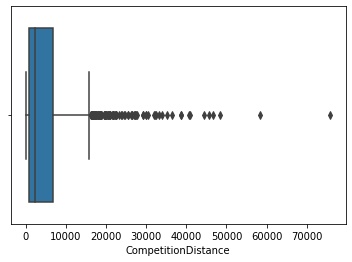

In [58]:
# scatter plot for competition distance
sns.boxplot(stores_df['CompetitionDistance'])

There are some outlier values in CompetitionDistance column, so we will replace null values with median values.

In [59]:
# creating a function to impute median
def impute_median(series):
  return series.fillna(series.median())

In [60]:
# applying impute median function to conver null values in stores data with median
stores_df['CompetitionDistance'] = stores_df['CompetitionDistance'].transform(impute_median)

In [61]:
stores_df['CompetitionDistance'].isnull().sum()

0

Replacing null values in "CompetitionOpenSinceMonth" and "CompetitionOpenSinceYear" with most frequent values, since competition distance for these rows are given.

In [62]:
stores_df['CompetitionOpenSinceMonth'].fillna(stores_df['CompetitionOpenSinceMonth'].mode()[0], inplace=True)
stores_df['CompetitionOpenSinceYear'].fillna(stores_df['CompetitionOpenSinceYear'].mode()[0], inplace=True)

Now, replacing null values in columns "Promo2SinceWeek", "Promo2SinceYear", and "PromoIntervals" with 0.

In [63]:
stores_df['Promo2SinceWeek'].fillna(0, inplace=True)
stores_df['Promo2SinceYear'].fillna(0, inplace=True)
stores_df['PromoInterval'].fillna(0, inplace=True)

Checking null values in stores dataframe again.

In [64]:
stores_df.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

Merging both the dataframes

In [65]:
df = df.merge(right = stores_df, how='left', on='Store')

In [66]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [67]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [68]:
df[(df['Promo']==1)&(df['Promo2']==1)].shape

(194016, 18)

In [69]:
df[(df['Promo']==0)&(df['Promo2']==1)].shape

(315162, 18)

In [70]:
ft = df[df['Promo2']==1]

In [71]:
df[df['Promo2']==1].tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1017199,1106,2,2013-01-01,0,0,0,0,a,1,a,c,5330.0,9.0,2011.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017200,1107,2,2013-01-01,0,0,0,0,a,1,a,a,1400.0,6.0,2012.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
1017202,1109,2,2013-01-01,0,0,0,0,a,1,c,a,3490.0,4.0,2011.0,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [72]:
df[(df['Sales']==0)&(df['Open']==0)].shape

(172817, 18)

In [73]:
#change into int type
df['StateHoliday'].replace({'0':0}, inplace=True)

In [74]:
df[(df['StateHoliday']!=0)&(df['Sales']!=0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
63559,5,4,2015-06-04,5807,625,1,1,a,0,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0
63560,6,4,2015-06-04,5749,614,1,1,a,0,a,a,310.0,12.0,2013.0,0,0.0,0.0,0
63609,55,4,2015-06-04,5984,702,1,1,a,0,a,a,720.0,11.0,2004.0,0,0.0,0.0,0
63611,57,4,2015-06-04,9301,870,1,1,a,0,d,c,420.0,6.0,2014.0,0,0.0,0.0,0
63614,60,4,2015-06-04,10399,850,1,1,a,0,d,c,5540.0,10.0,2009.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1,b,a,150.0,9.0,2006.0,0,0.0,0.0,0
1016827,733,2,2013-01-01,10765,2377,1,0,a,1,b,b,860.0,10.0,1999.0,0,0.0,0.0,0
1016863,769,2,2013-01-01,5035,1248,1,0,a,1,b,b,840.0,9.0,2013.0,1,48.0,2012.0,"Jan,Apr,Jul,Oct"
1017042,948,2,2013-01-01,4491,1039,1,0,a,1,b,b,1430.0,9.0,2013.0,0,0.0,0.0,0


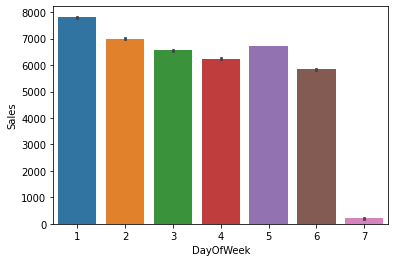

In [75]:
sns.barplot(x=df['DayOfWeek'], y=df['Sales'])

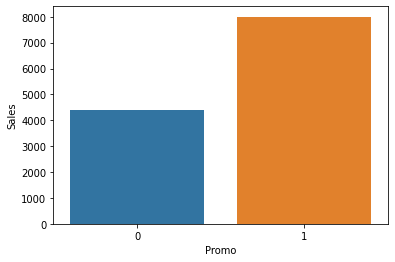

In [76]:
sns.barplot(x=df['Promo'], y=df['Sales'])

In [77]:
gf = df[(df['Promo']==1)&(df['Promo2']==1)]

In [78]:
gf.shape

(194016, 18)

In [79]:
gf.Sales.mean()

7588.424428913079

In [80]:
tf = df[(df['Promo']==1)&(df['Promo2']==0)]

In [81]:
tf.shape

(194064, 18)

In [82]:
tf.Sales.mean()

8393.780051941627

In [83]:
og = df[(df['Promo']==0)&(df['Promo2']==1)]

In [84]:
og.Sales.mean()

4091.1094643389747

In [85]:
df[df['Promo']==1].Sales.mean()

7991.152045969903

In [86]:
df[df['Promo2']==1].shape

(509178, 18)

In [87]:
df[df['Promo2']==1].Sales.mean()

5423.718218383355

In [88]:
yun = df.groupby('Store')['Promo2'].sum().reset_index()

In [89]:
yun[yun['Promo2']!=0].shape

(571, 2)

In [90]:
df['Date']

0          2015-07-31
1          2015-07-31
2          2015-07-31
3          2015-07-31
4          2015-07-31
              ...    
1017204    2013-01-01
1017205    2013-01-01
1017206    2013-01-01
1017207    2013-01-01
1017208    2013-01-01
Name: Date, Length: 1017209, dtype: object